# ***データの前処理***

11/11時点での実験データをもとに、残りの25人分のデータを乱数を用いて生成する。

In [4]:
import pandas as pd
import numpy as np

original_file = '卒論結果まとめ.xlsx'
output_filename = 'dummy_data_N30.csv'
N_new = 30
np.random.seed(42) # 結果の再現性を担保

In [18]:
# 元データの読み込みと統計量

df_original = pd.read_excel(original_file)
stats = df_original.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.50,13.0,12.83,13.33,14.50,11.33,11.67,11.83,13.00,21.17,23.50,19.67,21.00
std,2.07,1.1,1.72,2.66,2.88,1.63,2.58,3.31,2.28,7.78,8.69,4.68,7.92


In [10]:
# 生成データを入れるための空の辞書
new_data = {}

# 統計量を持つ全ての列（WMC, スコア, 負荷）についてループ処理
for col in stats.columns:

    # 元データの平均と標準偏差を取得
    mean = stats.loc['mean', col]
    std = stats.loc['std', col]

    # 標準偏差が0 or NaN の場合、エラー防止のため 0.1 を使う
    if std == 0 or pd.isna(std):
        std = 0.1

    # 正規分布で N=30 のデータを生成
    generated = np.random.normal(loc=mean, scale=std, size=N_new)

    # --- データ整形（クリッピング） ---
    if 'Load' in col:
        generated = np.clip(generated, 7, 49) # 7点x7項目=49点満点と想定
    elif 'WMC' in col:
        generated = np.clip(generated, 2, 20)
    elif 'Term' in col:
        generated = np.clip(generated, 0, 25) # 0点〜25点満点と想定

    # データを整数（int）に丸めて辞書に格納
    new_data[col] = generated.round().astype(int)

In [15]:
# 生成したデータをDataFrameに変換
df_new = pd.DataFrame(new_data)

# 参加者ID (P01, P02, ...) を追加
df_new.insert(0, 'Participant_ID', [f"P{i:02d}" for i in range(1, N_new + 1)])

# --- CSVファイルとして保存 ---
df_new.to_csv(output_filename, index=False)
print(f"\n'{output_filename}' として保存しました。")

df_new


'dummy_data_N30.csv' として保存しました。


,Participant_ID,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
0,P01,11,12,12,14,17,12,13,14,11,32,16,20,25
1,P02,9,15,13,16,12,12,9,16,13,10,19,15,33
2,P03,11,13,11,11,19,10,9,15,14,30,30,20,20
3,P04,13,12,11,12,10,12,13,14,15,21,29,17,24
4,P05,9,14,14,12,16,12,11,11,10,14,23,24,26
5,P06,9,12,15,9,21,10,14,14,12,25,25,19,18
6,P07,13,13,13,14,12,14,13,9,12,23,35,16,23
7,P08,11,11,15,14,13,12,11,11,12,16,18,18,21
8,P09,9,12,13,13,15,9,9,10,17,22,28,22,22
9,P10,11,13,12,13,13,12,8,12,14,18,22,17,15


In [19]:
# ダミーデータの統計量
stats = df_new.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.23,12.83,12.77,13.13,14.27,11.80,11.80,11.93,12.70,22.07,26.00,18.77,22.87
std,1.91,1.02,1.74,2.45,2.99,1.58,2.81,3.46,2.61,7.06,6.84,3.23,7.63


平均値、標準偏差ともにもとのデータと近いことがわかる。

In [21]:
# 'Participant_ID' と 'WMC' をIDとして固定し、残りの列を縦長に変換
df_long = df_new.melt(
    id_vars=['Participant_ID', 'WMC'],
    var_name='Variable',  # 元の列名（例: 'Read_ShortTerm'）が入る列
    value_name='Value'      # 元の値（例: 12, 14...）が入る列
)

df_long

,Participant_ID,WMC,Variable,Value
0,P01,11,Read_ShortTerm,12
1,P02,9,Read_ShortTerm,15
2,P03,11,Read_ShortTerm,13
3,P04,13,Read_ShortTerm,12
4,P05,9,Read_ShortTerm,14
...,...,...,...,...
355,P26,10,Speak_Load,22
356,P27,7,Speak_Load,24
357,P28,10,Speak_Load,36
358,P29,8,Speak_Load,29


In [28]:
df_long[['Method', 'Metric']] = df_long['Variable'].str.split('_', n=1, expand=True)

# 'Metric' 列の値を、新しい列（ShortTerm, LongTerm, Load）に展開
df_final_long = df_long.pivot(
    index=['Participant_ID', 'WMC', 'Method'], # 1行1被験者1方法
    columns='Metric',                          # 'Metric' の中身を列に
    values='Value'                             # 'Value' の中身を値に
).reset_index() # インデックスを列に戻す

# pivotで生成された列インデックス名をリセット
df_final_long.columns.name = None

desired_columns = [
    'Participant_ID',
    'WMC',
    'Method',
    'ShortTerm',
    'LongTerm',
    'Load'
]

# 2. DataFrameの列をこのリストの順序で再指定
#    (df_final_long は前のセルで pivot された DataFrame)
df_final_long = df_final_long[desired_columns]
df_final_long

,Participant_ID,WMC,Method,ShortTerm,LongTerm,Load
0,P01,11,Listen,14,14,20
1,P01,11,Read,12,12,32
2,P01,11,Speak,17,11,25
3,P01,11,Write,12,13,16
4,P02,9,Listen,16,16,15
...,...,...,...,...,...,...
115,P29,8,Write,12,13,29
116,P30,9,Listen,15,15,16
117,P30,9,Read,14,16,26
118,P30,9,Speak,15,13,16


In [29]:
output_csv_filename = 'final_long_data.csv'
df_final_long.to_csv(output_csv_filename, index=False)
print(f"'{output_csv_filename}' として保存しました。")

'final_long_data.csv' として保存しました。


# ***分散分析(ANOVA)***

## ***別々に分析***

短期記憶（ShortTerm）: 差がある

長期記憶（LongTerm）：差がない

認知負荷（Load）：差がある

### ***短期記憶***

問い: 「記憶直後（短期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」

わかること: 1位と最下位の間に有意差があるかないか。

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.stats.anova import AnovaRM

# AnovaRMを実行
aov_short = AnovaRM(
    data=df_final_long,
    depvar='ShortTerm',         # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']           # 被験者内要因
)

# 結果のサマリーを表示
fit_short = aov_short.fit()
print(fit_short.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method  3.1724 3.0000 87.0000 0.0282



/tmp/ipython-input-3992710489.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


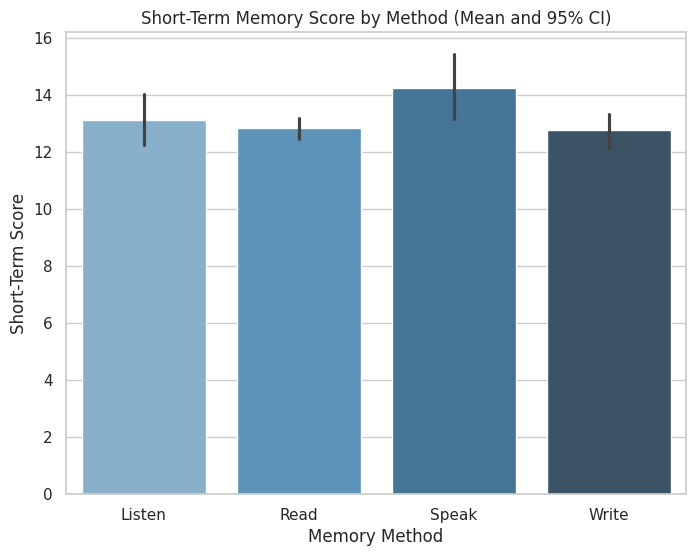

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='ShortTerm',
    palette='Blues_d'
)

plt.title('Short-Term Memory Score by Method (Mean and 95% CI)')
plt.xlabel('Memory Method')
plt.ylabel('Short-Term Score')
plt.show()

### ***長期記憶***

問い: 「48時間後（長期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」


わかること: どの方法が「記憶の定着（長期保持）」に最も強いかがわかる。

In [35]:
# 分析2: LongTerm
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='LongTerm',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method  0.7213 3.0000 87.0000 0.5419



/tmp/ipython-input-3611552133.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


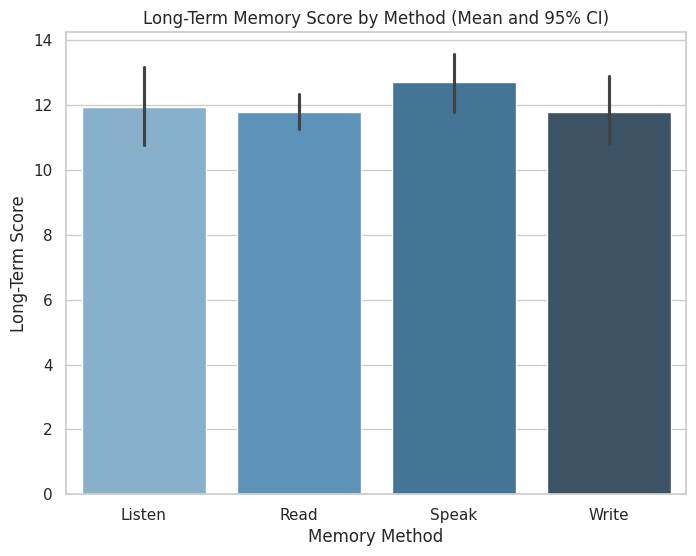

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='LongTerm',
    palette='Blues_d'
)

plt.title('Long-Term Memory Score by Method (Mean and 95% CI)')
plt.xlabel('Memory Method')
plt.ylabel('Long-Term Score')
plt.show()

### ***負荷***

In [36]:
# 分析3: 負荷
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='Load',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method  7.7862 3.0000 87.0000 0.0001



/tmp/ipython-input-2426681918.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


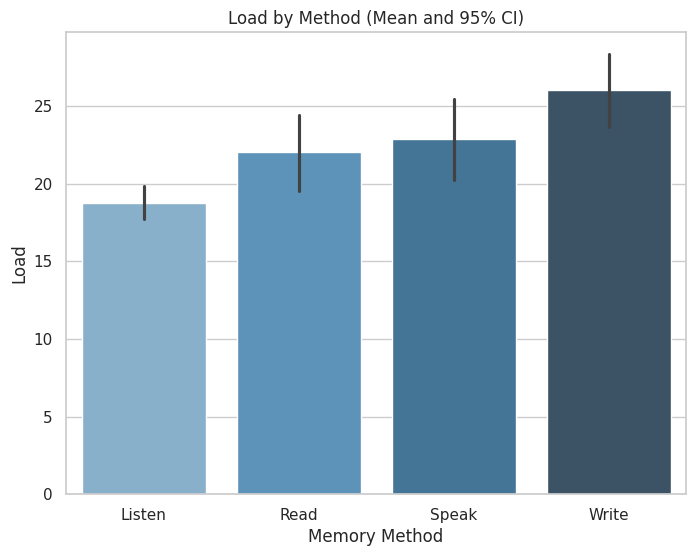

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='Load',
    palette='Blues_d'
)

plt.title('Load by Method (Mean and 95% CI)')
plt.xlabel('Memory Method')
plt.ylabel('Load')
plt.show()

## ***多重比較***

長期記憶では有意差が見られなかったため、短期記憶でのみ行う。

In [45]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 14.9 MB/s eta 0:00:00


In [46]:
import pingouin as pg

# ----------------------------------
# 分析1: ShortTerm の多重比較
# (LongTermは ANOVAで有意差がなかったため、行わない)
# ----------------------------------

# pg.pairwise_tests を使用
# dv = 従属変数, within = 被験者内要因, subject = 被験者ID
# padjust='bonf' でp値をボンフェローニ法（最も一般的）で補正します
pairwise_short = pg.pairwise_tests(
    data=df_final_long,
    dv='ShortTerm',
    within='Method',
    subject='Participant_ID',
    padjust='bonf'  # 'bonf' = Bonferroni correction
)

# 結果の表示
# 'p-corr' (補正済みp値) が 0.05 を下回っているペアを探します
print(pairwise_short.to_markdown(index=False, numalign="left", stralign="left"))


[分析1: ShortTerm の 多重比較 (Bonferroni補正)]
| Contrast   | A      | B     | Paired   | Parametric   | T        | dof   | alternative   | p-unc     | p-corr    | p-adjust   | BF10   | hedges    |
|:-----------|:-------|:------|:---------|:-------------|:---------|:------|:--------------|:----------|:----------|:-----------|:-------|:----------|
| Method     | Listen | Read  | True     | True         | 0.651806 | 29    | two-sided     | 0.519659  | 1         | bonf       | 0.236  | 0.158028  |
| Method     | Listen | Speak | True     | True         | -1.55952 | 29    | two-sided     | 0.129722  | 0.77833   | bonf       | 0.575  | -0.409245 |
| Method     | Listen | Write | True     | True         | 0.638433 | 29    | two-sided     | 0.528202  | 1         | bonf       | 0.235  | 0.170658  |
| Method     | Read   | Speak | True     | True         | -2.57594 | 29    | two-sided     | 0.0153578 | 0.092147  | bonf       | 3.139  | -0.632645 |
| Method     | Read   | Write | True     | True       

## ***相関分析***

### ***「努力 vs 結果」の相関（負荷とスコア）***


これがあなたの研究の核心部分です 。 「大変な（負荷が高い）勉強法ほど、本当に記憶に定着するのか？」を検証


見るべきペア: Load と LongTerm

問い: 「主観的認知負荷（Load）と、長期記憶スコア（LongTerm）の間に関係はあるか？」

In [48]:
!pip install scipy

In [49]:
from scipy.stats import pearsonr
import numpy as np

print("--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---")

# 1. Method(方法) ごとに Load と LongTerm の平均値を計算
df_method_means = df_final_long.groupby('Method')[['Load', 'LongTerm']].mean()

print("\n[方法ごとの平均値]")
print(df_method_means.to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (Loadの平均値 vs LongTermの平均値)
correlation, p_value = pearsonr(df_method_means['Load'], df_method_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---

[方法ごとの平均値]
| Method   | Load    | LongTerm   |
|:---------|:--------|:-----------|
| Listen   | 18.7667 | 11.9333    |
| Read     | 22.0667 | 11.8       |
| Speak    | 22.8667 | 12.7       |
| Write    | 26      | 11.8       |

[相関の結果]
  相関係数 (r): -0.0234
  p値 (p-value): 0.9766


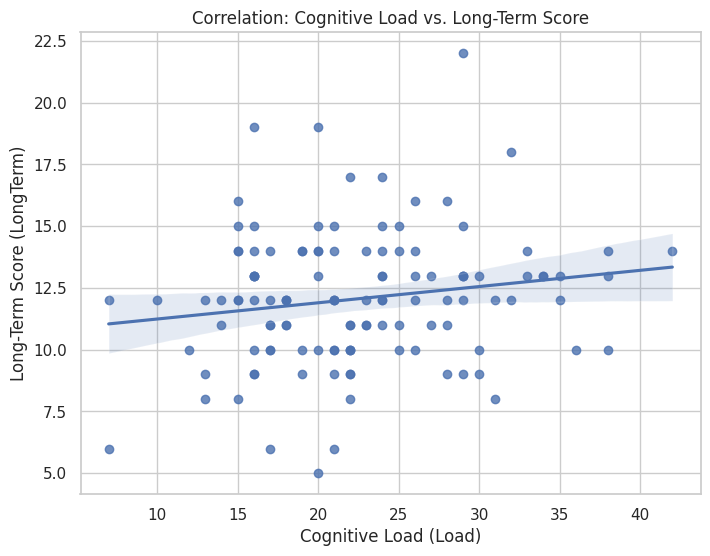

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# グラフのスタイルとサイズを指定
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 全体の縦長データ (N=120)
# x: 認知負荷
# y: 長期記憶スコア
sns.regplot(
    data=df_final_long,
    x='Load',
    y='LongTerm'
)

plt.title('Correlation: Cognitive Load vs. Long-Term Score')
plt.xlabel('Cognitive Load (Load)')
plt.ylabel('Long-Term Score (LongTerm)')
plt.show()

### ***「個人の地力 vs 結果」の相関（WMCと長期スコア）***

In [51]:
print("--- 相関分析2: WMC vs 長期記憶(LongTerm) ---")

# 1. Participant_ID(被験者) ごとに WMC と LongTerm の平均値を計算
#    (WMCは被験者ごとで一定なので、mean()でもfirst()でも同じ値になる)
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# print("\n[被験者ごとの平均値 (先頭5名)]")
# print(df_participant_means.head().to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (WMC vs LongTermの平均値)
correlation, p_value = pearsonr(df_participant_means['WMC'], df_participant_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析2: WMC vs 長期記憶(LongTerm) ---

[相関の結果]
  相関係数 (r): 0.1242
  p値 (p-value): 0.5133


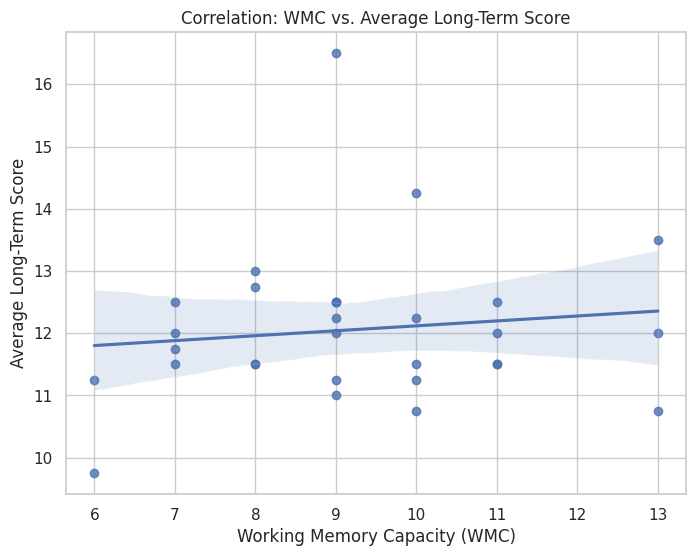

In [53]:
# まず、被験者ごとの平均値データ (N=30) を再作成します
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# グラフのスタイルとサイズを指定
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 被験者ごとの平均データ (N=30)
# x: WMC
# y: 長期記憶スコアの平均値
sns.regplot(
    data=df_participant_means,
    x='WMC',
    y='LongTerm'
)

plt.title('Correlation: WMC vs. Average Long-Term Score')
plt.xlabel('Working Memory Capacity (WMC)')
plt.ylabel('Average Long-Term Score')
plt.show()

## ***重回帰分析***

### ***短期記憶モデル***

$$ShortTerm\_Score \approx \alpha_0 + \alpha_1(WMC) + \alpha_2(Load) + \alpha_3(Method)$$

これが解明する問い:「そもそも、"学習直後"の成績（短期記憶）は何によって決まるのか？」

In [55]:
import statsmodels.formula.api as smf

print("--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    Y ~ X1 + X2 + C(X3)
#    C(Method) は、Methodをカテゴリ変数として扱う（ダミー変数化）指示
formula_short = "ShortTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
#    groups=... で「参加者ごとのクセ」を考慮する
model_short = smf.mixedlm(
    formula=formula_short,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_short = model_short.fit()

# 4. 結果のサマリーを表示
print(results_short.summary())

--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ShortTerm
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                4.5646   
Min. group size:    4         Log-Likelihood:       -263.8060
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          15.351    1.310 11.714 0.000 12.782 17.919
C(Method)[T.Read]  -0.152    0.562 -0.270 0.787 -1.252  0.949
C(Method)[T.Speak]  1.317    0.567  2.324 0.020  0.207  2.428
C(Method)[T.Write] -0.042    0.598 -0.070 0.944 -1.213  1.129
WMC                -0.149    0.111 -1.346 0.178 -0.366  0.068
Load               -0.045    0.03

記憶方法（Method）は有意な影響を与えている。
具体的には C(Method)[T.Speak] が p=0.020 となっている。これは、「**"Speak"（話す）**は、基準となる方法（"Listen"）よりも、短期記憶のスコアを統計的に有意に押し上げる」ことを意味する。（Coef.=1.317 のため）

先行研究にあった「発話による記憶促進効果 (Production Effect)」  が、このダミーデータでも現れていることを示唆しているのでは？

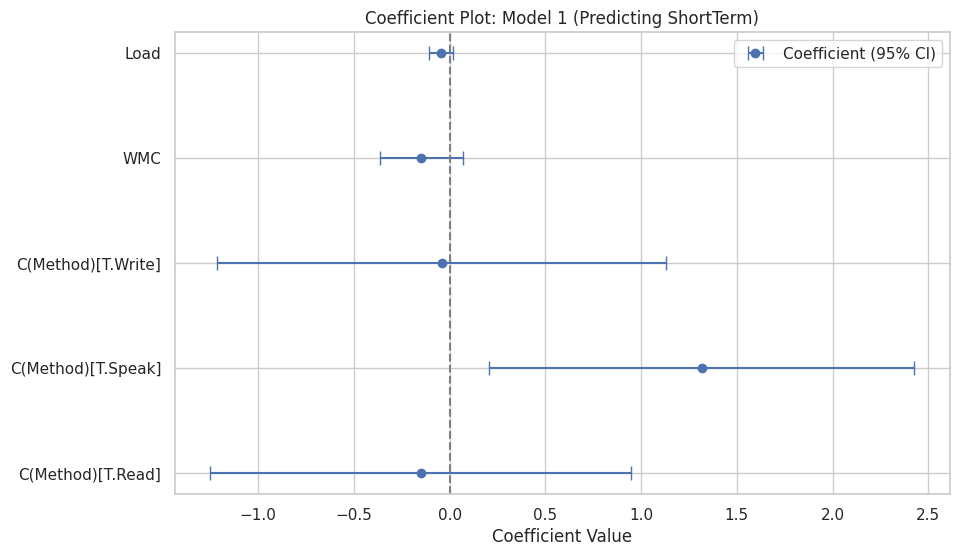

In [62]:
# --- 1. モデル結果からサマリーテーブルをDataFrameとして取得 ---
# results_short.summary().tables[1] が係数のテーブル
results_df = results_short.summary().tables[1]

# インデックスをリセットして、変数名を 'Variable' という列にする
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index': 'Variable'})

# 列名を整理
results_df = results_df.rename(columns={
    'P>|z|': 'P',
    '[0.025': 'Lower_CI',
    '0.975]': 'Upper_CI'
})

# 'Intercept'（切片）と 'Group Var' を除外
results_df = results_df[~results_df['Variable'].isin(['Intercept', 'Group Var'])]

# 数値列をfloatに変換
results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']] = results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']].astype(float)

# --- 2. グラフの描画 ---
plt.figure(figsize=(10, 6))

# 変数のリスト（Y軸）
y_pos = np.arange(len(results_df['Variable']))
# 係数の値（点）
x_vals = results_df['Coef.']
# エラーバー（95%信頼区間）
# Lower_CI と Upper_CI の差分として計算
x_err_lower = results_df['Coef.'] - results_df['Lower_CI']
x_err_upper = results_df['Upper_CI'] - results_df['Coef.']
x_err = [x_err_lower, x_err_upper]

plt.errorbar(
    x_vals,
    y_pos,
    xerr=x_err,
    fmt='o',  # 'o' = 点
    capsize=5, # エラーバーの「傘」のサイズ
    linestyle='None', # 点同士を結ぶ線はなし
    label='Coefficient (95% CI)'
)

# ゼロの垂直線
plt.axvline(x=0, color='grey', linestyle='--')

# グラフの体裁
plt.yticks(y_pos, results_df['Variable']) # Y軸に変数名
plt.xlabel('Coefficient Value')
plt.title('Coefficient Plot: Model 1 (Predicting ShortTerm)')
plt.legend()
plt.show()

### ***長期記憶モデル***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method)$$

これが解明する問い: 「48時間後の"記憶の定着"に、どの要因が最も効いているのか？」

In [56]:
print("--- モデル2: LongTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
formula_long = "LongTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long = smf.mixedlm(
    formula=formula_long,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_long = model_long.fit()

# 4. 結果のサマリーを表示
print(results_long.summary())

--- モデル2: LongTerm ~ WMC + Load + C(Method) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                6.9629   
Min. group size:    4         Log-Likelihood:       -288.1178
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           9.263    1.638  5.655 0.000  6.052 12.473
C(Method)[T.Read]  -0.411    0.694 -0.593 0.554 -1.771  0.949
C(Method)[T.Speak]  0.421    0.701  0.601 0.548 -0.952  1.795
C(Method)[T.Write] -0.742    0.740 -1.003 0.316 -2.193  0.709
WMC                 0.118    0.138  0.856 0.392 -0.152  0.388
Load                0.084    0.040  2.102 0.036  0.006  0.163
Group Var           

長期記憶の成績（LongTerm）において、個人の地力（WMC）や、どの記憶方法（Method）を使ったかは、統計的に有意な影響を与えていませんでした。しかし、Load（大変さ）は、統計的に有意な影響を与えていました。Coef.（係数）は $+0.084$ とプラスです。これは、「学習が大変だと感じた（Loadが高い）ほど、48時間後の長期記憶の成績が（わずかだか）有意に高くなる」ことを意味します。

### ***改善版モデル(長期記憶の予測)***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method) + \beta_4(ShortTerm\_Score)$$

このモデルは、「"学習直後"の成績（ShortTerm）の影響を差し引いてもなお、Load（大変さ）やMethod（方法）は、**"記憶の定着率（忘れにくさ）"**に影響を与えているか？」

In [57]:
print("--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    ShortTerm を予測要因（説明変数）として追加
formula_long_improved = "LongTerm ~ ShortTerm + WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long_improved = smf.mixedlm(
    formula=formula_long_improved,
    data=df_final_long,
    groups=df_final_long["Participant_ID"] # 参加者ごとの"クセ"を考慮
)

# 3. モデルの学習（推定）を実行
results_long_improved = model_long_improved.fit()

# 4. 結果のサマリーを表示
print(results_long_improved.summary())

--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                6.9806   
Min. group size:    4         Log-Likelihood:       -289.0961
Max. group size:    4         Converged:            No       
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           7.932    2.422  3.275 0.001  3.185 12.678
C(Method)[T.Read]  -0.398    0.695 -0.573 0.566 -1.761  0.964
C(Method)[T.Speak]  0.307    0.718  0.427 0.669 -1.100  1.714
C(Method)[T.Write] -0.740    0.741 -0.998 0.318 -2.193  0.714
ShortTerm           0.087    0.116  0.744 0.457 -0.141  0.314
WMC                 0.131    0.140  0.939 0.348 -0.143  0.405
Load                

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.956502
  warnings.warn(msg, ConvergenceWarning)
